In [137]:
## Example code for BENG 260 Homework 2, Fall 2017
## Questions to vramesh@eng.ucsd.edu or gert@ucsd.edu

import scipy as sp
import pylab as plt
from scipy.integrate import odeint
import numpy as np
import random

In [146]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


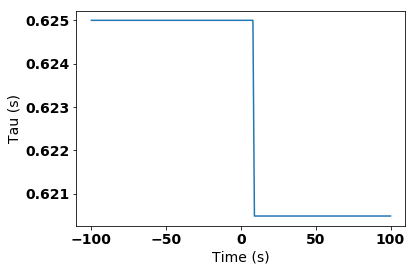

In [186]:
# Problem 1b
# compute Tau from -100:100

A0 = 0.7
B0 = 0.9
LAM = MU = .01
t_input = 8
t_step = .01
t = np.arange(0,16,t_step)
t_tau = np.arange(-100,101,1)
Vm = np.zeros(len(t))
Vm[t>8] = 30
Vm_tau = np.zeros(len(t_tau))

Vm_tau[t_tau>t_input] = 30
An_tau = A0*np.exp(LAM*Vm_tau)
Bn_tau = B0*np.exp(-MU*Vm_tau)

An = A0*np.exp(LAM*Vm)
Bn = B0*np.exp(-MU*Vm)

def An_f(Vm):
    return A0*np.exp(LAM*Vm)
def Bn_f(Vm):
    return B0*np.exp(-MU*Vm)

Tau = 1/(An_tau+Bn_tau)
plt.plot(t_tau,Tau)
plt.xlabel('Time (s)')
plt.ylabel('Tau (s)')
plt.tight_layout()
#plt.savefig('Part1b.png')
plt.show()

/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


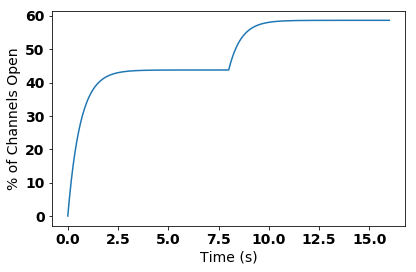

In [187]:
# problem 1b
def dndt(n, t):
    if t>8:
        Vm = 30
    else:
        Vm = 0
    return An_f(Vm)*(1-n) - Bn_f(Vm)*n
n_t = odeint(dndt,0,t)*100
plt.plot(t,n_t)
plt.xlabel('Time (s)')
plt.ylabel('% of Channels Open')
plt.tight_layout()
#plt.savefig('Part1c.png')
plt.show()

In [190]:
# t_step = .1
# t = np.arange(0,16,t_step)
def n_t_markov(N):
#N = 1000 #- # of gates
    gates = np.zeros(N)
    n_open = np.zeros(len(t))

    for t_ind in range(len(t)):
        for gate_i in range(N):
            prob_sample = random.uniform(0,1)
            if gates[gate_i] == 0:
                gates[gate_i] = prob_sample < (t_step*An_f(Vm[t_ind]))
            else:
                gates[gate_i] = prob_sample < (1-t_step*Bn_f(Vm[t_ind]))
        n_open[t_ind] = np.mean(gates)*100
    return n_open



In [189]:
n_open_1 = n_t_markov(1)
n_open_400 = n_t_markov(400)
n_open_1000 = n_t_markov(1000)

(1600,) (1600,)


/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


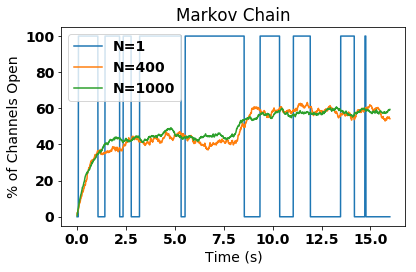

In [194]:
print(np.shape(t),np.shape(n_open_1))
plt.plot(t,n_open_1,label = 'N=1')
plt.plot(t,n_open_400,label = 'N=400')
plt.plot(t,n_open_1000,label = 'N=1000')
plt.legend(loc=2)
plt.xlabel('Time (s)')
plt.ylabel('% of Channels Open')
plt.title('Markov Chain')
plt.tight_layout()
#plt.savefig('Part1d_1.png')
plt.show()

/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


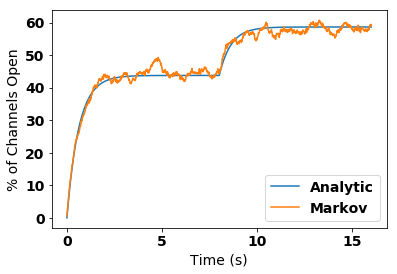

In [193]:
plt.plot(t,n_t,label='Analytic')
plt.plot(t,n_open_1000,label='Markov')
plt.xlabel('Time (s)')
plt.ylabel('% of Channels Open')
plt.legend()
#plt.tight_layout()
#plt.savefig('Part1d_2.png')
plt.show()

In [196]:
###########################################################
## Problem 2: Morris-Lecar (barnacle muscle fiber) Model ##
###########################################################
# Constants
C_m  =   1.0 # membrane capacitance, in uF/cm^2
g_Ca =   1.1 # maximum conducances, in mS/cm^2
g_K  =   36
g_L  =   0.3
g_Na =   120
E_Ca = 100.0 # Nernst reversal potentials, in mV
E_K  = -12.0
E_L  = 10.613
E_Na = 115
# Channel gating kinetics
# Functions of membrane voltage
def m_infty(V): return (1.0 + sp.tanh((V + 1.0) / 15.0)) / 2.0
def w_infty(V): return (1.0 + sp.tanh(V / 30.0)) / 2.0
def tau_w(V):   return 5.0 / sp.cosh(V / 60.0)  # in ms

# Membrane currents (in uA/cm^2)
def I_Ca(V):    return g_Ca * m_infty(V) * (V - E_Ca)
def I_K(V, w):  return g_K  * w          * (V - E_K)
def I_L(V):     return g_L               * (V - E_L)

# External current
# step up 10 uA/cm^2 every 100ms
def I_ext(t): return 10*sp.floor(t/100)+10

# The time to integrate over and the overall current trace
t = sp.arange(0.0, 400.0, 0.1)
I = I_ext(t)

In [197]:
def a_m(V): return (25-V)/(10*(np.exp((25-V)/10)-1))
def b_m(V): return 4*np.exp(-V/18)
def a_h(V): return 0.07*np.exp(-V/20)
def b_h(V): return 1/(np.exp((30-V)/10)+1)
def a_n(V): return (10-V)/(100*(np.exp((10-V)/10)-1))
def b_n(V): return 0.125*np.exp(-V/80)

/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


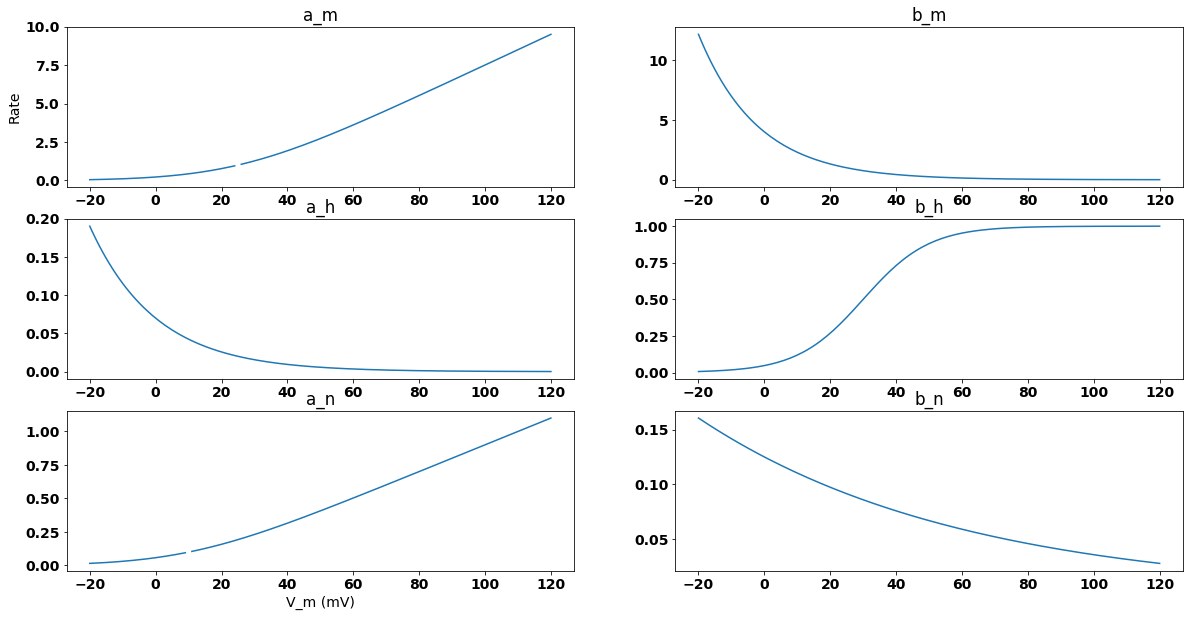

In [198]:
V = np.arange(-20,121,1)
plt.figure(figsize=(20,10))
plt.subplot(3,2,1)
plt.plot(V,a_m(V),label='a_m')
#plt.xlabel('V_m (mV)')
plt.ylabel('Rate')
plt.title('a_m')

plt.subplot(3,2,2)
plt.plot(V,b_m(V),label='b_m')
plt.title('b_m')

plt.subplot(3,2,3)
plt.plot(V,a_h(V),label='a_h')
# plt.xlabel('V_m (mV)')

plt.title('a_h')

plt.subplot(3,2,4)
plt.plot(V,b_h(V),label='b_h')
plt.title('b_h')

plt.subplot(3,2,5)
plt.plot(V,a_n(V),label='a_n')
plt.title('a_n')
plt.xlabel('V_m (mV)')

plt.subplot(3,2,6)
plt.plot(V,b_n(V),label='b_n')
plt.title('b_n')

#plt.savefig('Part2a.png')
plt.show()

/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


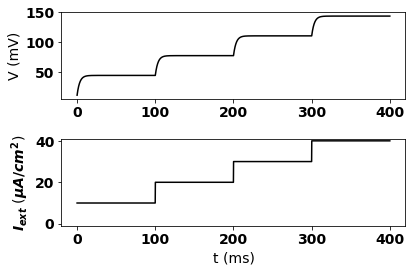

In [204]:
########################################
## Problem 2.2: leaky passive neuron
def dVdt_leak(V, t): return (I_ext(t) - I_L(V)) / C_m
V_leak = odeint(dVdt_leak, E_L, t)

plt.figure()

plt.subplot(2,1,1)
#plt.title('2.2: Leaky Passive Neuron')
plt.plot(t, V_leak, 'k')
plt.ylabel('V (mV)')

plt.subplot(2,1,2)
plt.plot(t, I, 'k')
plt.xlabel('t (ms)')
plt.ylabel('$I_{ext}$ ($\\mu{A}/cm^2$)')
plt.ylim(-1, I[len(I)-1]+1)
plt.tight_layout()
#plt.savefig('Part2b.png')
plt.show()

In [205]:
# 2d
def Vm_dynamics(I_E):
    l_t = len(t)
    m_t = np.zeros(l_t)
    n_t = np.zeros(l_t)
    h_t = np.zeros(l_t)
    v_t = np.zeros(l_t)
    m_t_inf = np.zeros(l_t)
    # starting values
    v_t[0] = 0
    m_t[0] = a_m(v_t[0])/(a_m(v_t[0]) + b_m(v_t[0]))
    h_t[0] = a_h(v_t[0])/(a_h(v_t[0]) + b_h(v_t[0]))
    n_t[0] = a_n(v_t[0])/(a_n(v_t[0]) + b_n(v_t[0]))
    m_t_inf[0] = a_m(v_t[0])/(a_m(v_t[0])+b_m(v_t[0]))
    for i in range(l_t-1):

        t_i = i+1
        v_i = v_t[i]

        m_t[t_i] = (a_m(v_i)*(1-m_t[i])-b_m(v_i)*m_t[i])*t_step+m_t[i]
        n_t[t_i] = (a_n(v_i)*(1-n_t[i])-b_n(v_i)*n_t[i])*t_step+n_t[i]
        h_t[t_i] = (a_h(v_i)*(1-h_t[i])-b_h(v_i)*h_t[i])*t_step+h_t[i]
        
        m_t_inf[t_i] = a_m(v_i)/(a_m(v_i)+b_m(v_i))

        I_NA = g_Na*m_t[t_i]**3*h_t[t_i]*(v_i-E_Na)
        I_K = g_K*n_t[t_i]**4*(v_i-E_K)
        I_L = g_L*(v_i-E_L)

        v_t[t_i] = (1/C_m*(-I_NA-I_K-I_L+I_E))*t_step+v_i
        
    return v_t, n_t, h_t, m_t, m_t_inf

/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


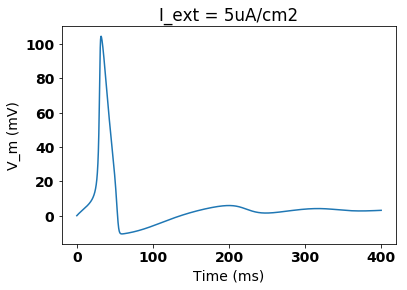

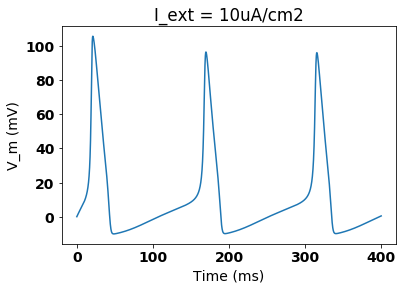

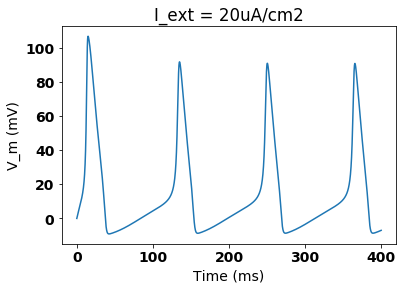

In [201]:
v_t_10,_,_,_,_ = Vm_dynamics(10)
v_t_5,_,_,_,_ = Vm_dynamics(5)
v_t_20,_,_,_,_ = Vm_dynamics(20)

plt.plot(t,v_t_5)
plt.title('I_ext = 5uA/cm2')
plt.xlabel('Time (ms)')
plt.ylabel('V_m (mV)')
plt.savefig('Part2c_1.png')
plt.show()

plt.plot(t,v_t_10)
plt.title('I_ext = 10uA/cm2')
plt.xlabel('Time (ms)')
plt.ylabel('V_m (mV)')
plt.savefig('Part2c_2.png')
plt.show()

plt.plot(t,v_t_20)
plt.title('I_ext = 20uA/cm2')
plt.xlabel('Time (ms)')
plt.ylabel('V_m (mV)')
plt.savefig('Part2c_3.png')
plt.show()

In [206]:
from sklearn import linear_model
v_t,n_t,h_t,m_t,m_t_inf = Vm_dynamics(10)

/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


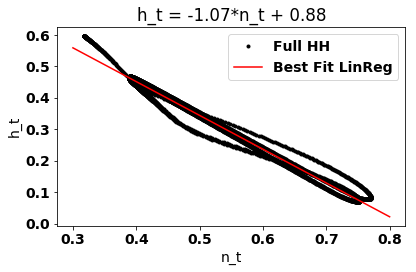

In [207]:
# help(linear_model)
tmp = np.arange(.3,.85,.05)
tmp = tmp.reshape(-1,1)
lm = linear_model.LinearRegression()
X = n_t.reshape(-1,1)
Y = h_t.reshape(-1,1)
np.shape(X)
model = lm.fit(X,Y)
c_1_h = model.coef_[0]
c_0_h = model.intercept_[0]

pred = model.predict(tmp)
#tit = print('h_t = {0:.2f}*n_t + {1:.2f}' .format(c_1[0], c_0))

plt.plot(n_t,h_t,'k.',label = 'Full HH')
plt.plot(tmp,pred,'r',label = 'Best Fit LinReg')
plt.xlabel('n_t')
plt.ylabel('h_t')
plt.legend()
plt.title('h_t = {0:.2f}*n_t + {1:.2f}' .format(c_1_h[0], c_0_h))
plt.tight_layout()
#plt.savefig('Part3a.png')
plt.show()


/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


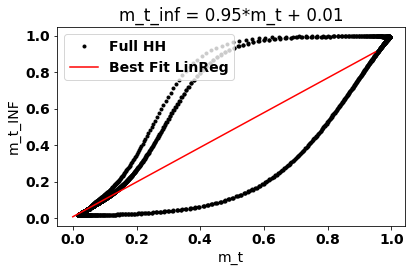

In [208]:
X = m_t.reshape(-1,1)
Y = m_t_inf.reshape(-1,1)

tt = np.arange(0,1,.05)
tt = tt.reshape(-1,1)
model = lm.fit(X,Y)
c_1 = model.coef_[0]
c_0 = model.intercept_[0]
pred = model.predict(tt)

plt.plot(m_t,m_t_inf,'k.',label = 'Full HH')
plt.plot(tt,pred,'r',label = 'Best Fit LinReg')
plt.xlabel('m_t')
plt.ylabel('m_t_INF')

plt.legend()
plt.title('m_t_inf = {0:.2f}*m_t + {1:.2f}' .format(c_1[0], c_0))
plt.tight_layout()
plt.savefig('Part3b.png')
plt.show()


In [209]:
def Vm_dynamics_2V(I_E,c_0,c_1):
    
    l_t = len(t)
    #m_t = np.zeros(l_t)
    n_t = np.zeros(l_t)
    h_t = np.zeros(l_t)
    v_t = np.zeros(l_t)
    m_t = np.zeros(l_t)
    # starting values
    v_t[0] = 0
    #m_t[0] = a_m(v_t[0])/(a_m(v_t[0]) + b_m(v_t[0]))
    h_t[0] = a_h(v_t[0])/(a_h(v_t[0]) + b_h(v_t[0]))
    n_t[0] = a_n(v_t[0])/(a_n(v_t[0]) + b_n(v_t[0]))
    m_t[0] = a_m(v_t[0])/(a_m(v_t[0])+b_m(v_t[0]))
    for i in range(l_t-1):

        t_i = i+1
        v_i = v_t[i]

        #m_t[t_i] = (a_m(v_i)*(1-m_t[i])-b_m(v_i)*m_t[i])*t_step+m_t[i]
        n_t[t_i] = (a_n(v_i)*(1-n_t[i])-b_n(v_i)*n_t[i])*t_step+n_t[i]
        #h_t[t_i] = (a_h(v_i)*(1-h_t[i])-b_h(v_i)*h_t[i])*t_step+h_t[i]
        h_t[t_i] = c_0 + c_1*n_t[t_i]
        
        m_t[t_i] = a_m(v_i)/(a_m(v_i)+b_m(v_i)) # use m_t_inf

        I_NA = g_Na*m_t[t_i]**3*h_t[t_i]*(v_i-E_Na)
        I_K = g_K*n_t[t_i]**4*(v_i-E_K)
        I_L = g_L*(v_i-E_L)

        v_t[t_i] = (1/C_m*(-I_NA-I_K-I_L+I_E))*t_step+v_i
        
    return v_t

/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


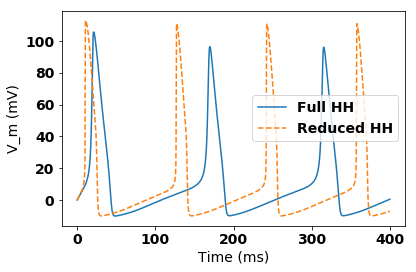

In [210]:
I_E = 10
v_t_full,_,_,_,_ = Vm_dynamics(I_E)
v_t_reduced = Vm_dynamics_2V(I_E,c_0_h,c_1_h)
plt.plot(t,v_t_full,label = 'Full HH')
plt.plot(t,v_t_reduced,'--',label = 'Reduced HH')
plt.xlabel('Time (ms)')
plt.ylabel('V_m (mV)')
plt.legend()
plt.tight_layout()
plt.savefig('Part3c.png')
plt.show()